In [1]:
import sys

sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

# import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

/opt/conda/envs/lilo/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sns.set_theme(style = "whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [5]:
%config InlineBackend.figure_format = 'retina'

# Random vs. cosine similarity

In [6]:
EXPERIMENT_DIR = "lilo_arxiv_v1"
EXPERIMENT_NAME = "compare_lilo_synthetic"

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [7]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_dir=EXPERIMENT_DIR,
    experiment_name=EXPERIMENT_NAME,
    experiment_types=[
        "cos_similar",
        "random",
    ],
    allow_incomplete_results=True,
    compute_likelihoods=True,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../lilo_arxiv_v1/outputs/compare_lilo_synthetic
Available domains: ['re2', 'clevr', 'logo']


In [8]:
df_results = analyzer.get_synthesis_summary()
df_results = analyzer.format_dataframe_camera(df_results)
df_results = df_results[df_results['Split'] == 'test'].copy()
df_results

,domain,Model,seed,Iteration,Split,n_solved,Tasks solved (%)
168,REGEX,Cosine Similarity,111,0,test,208,41.600000
172,REGEX,Cosine Similarity,111,3,test,261,52.200000
176,REGEX,Cosine Similarity,111,6,test,339,67.800000
180,REGEX,Cosine Similarity,111,9,test,354,70.800000
184,REGEX,Cosine Similarity,111,12,test,353,70.600000
...,...,...,...,...,...,...,...
152,LOGO,Random,222,9,test,35,31.531532
154,LOGO,Random,333,0,test,15,13.513514
158,LOGO,Random,333,3,test,15,13.513514
162,LOGO,Random,333,6,test,42,37.837838


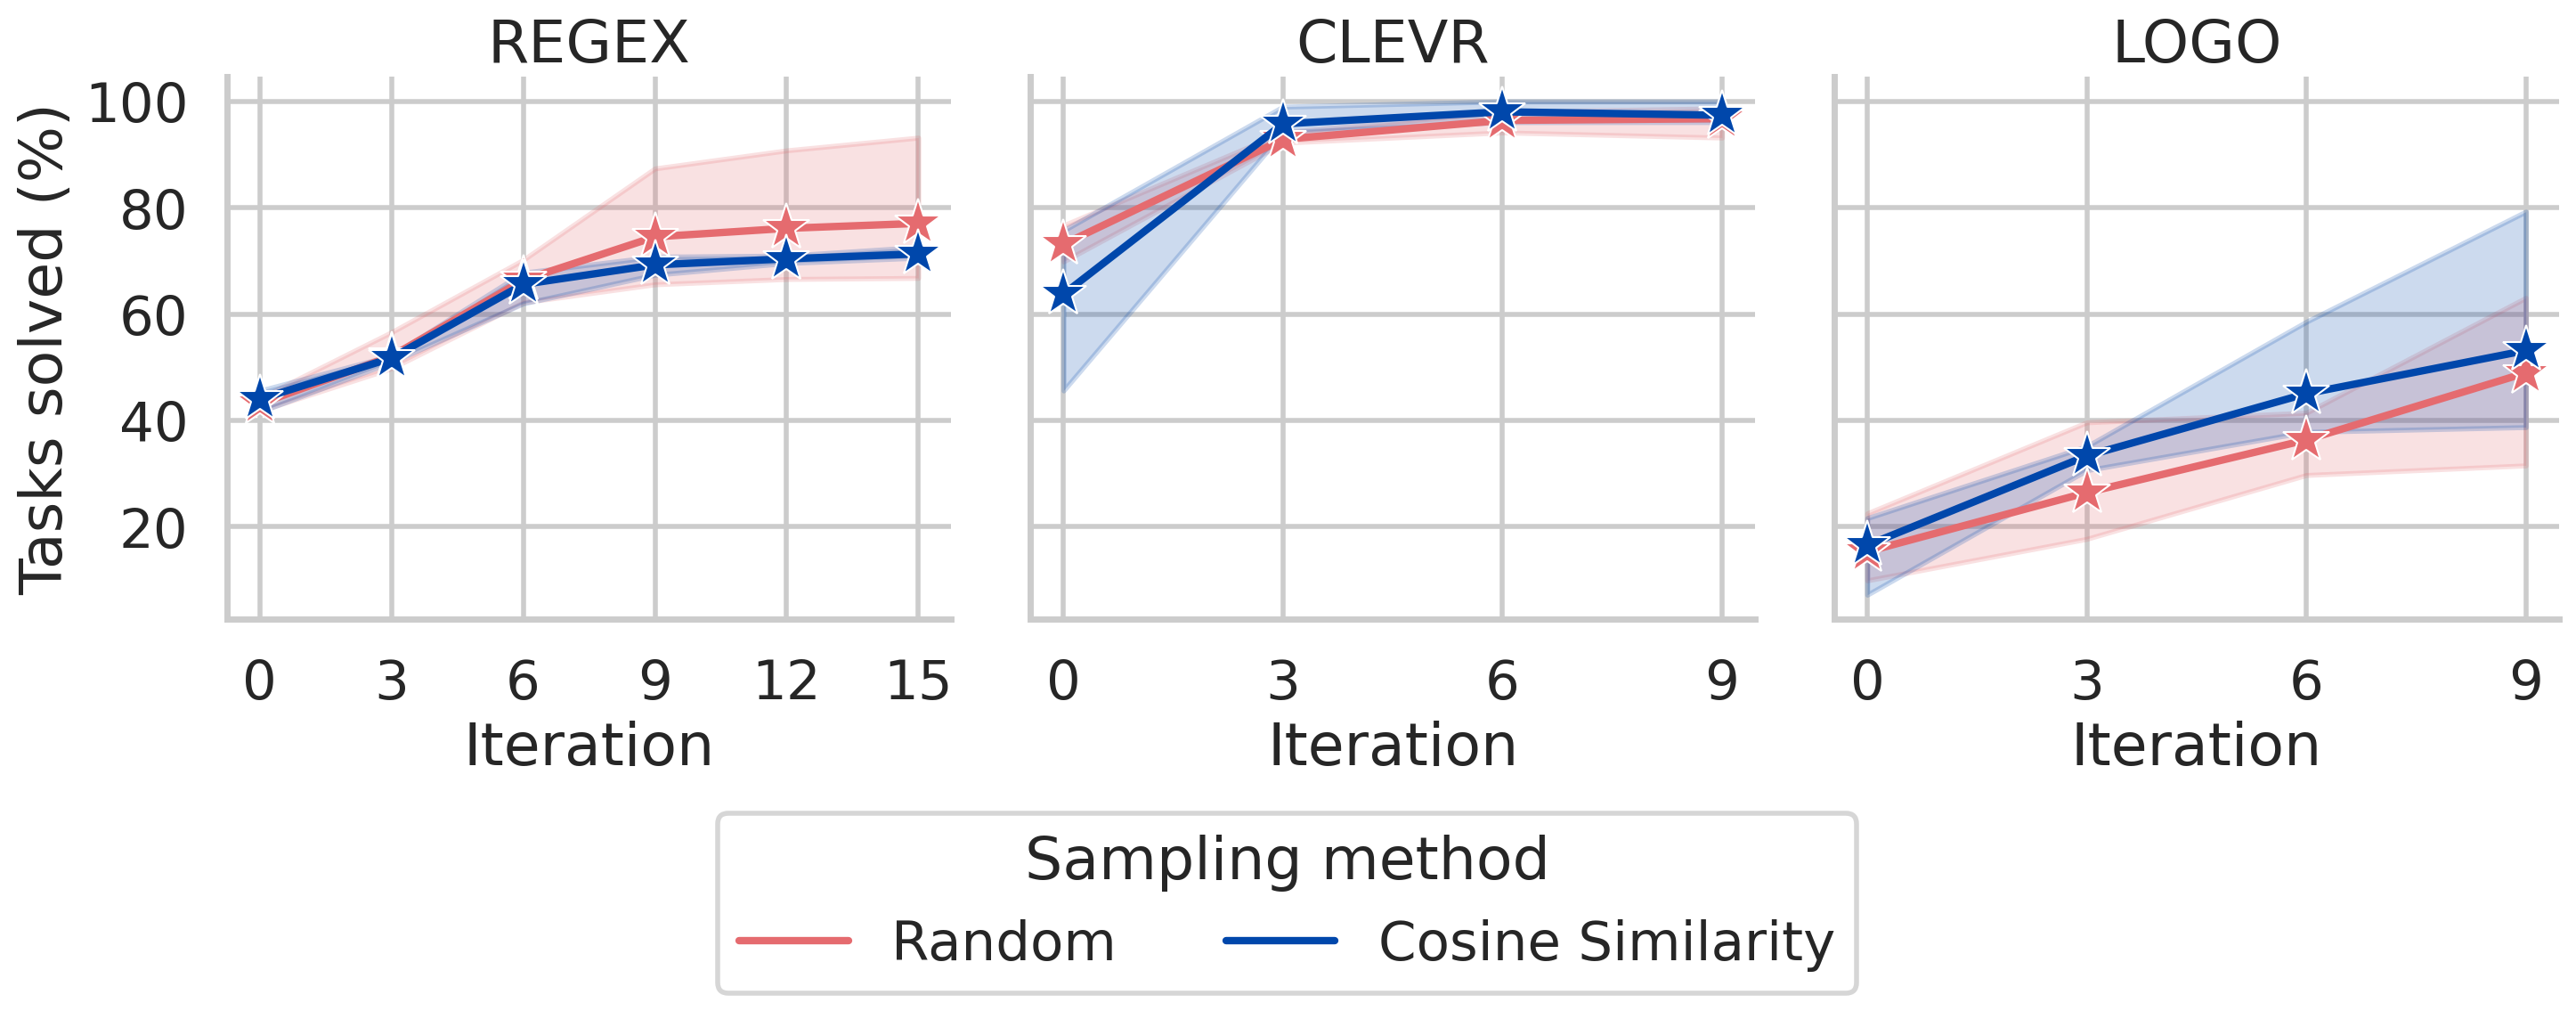

In [9]:
# plot random vs cos similar
analyzer.EXPERIMENT_TYPES_PALETTE['Random'] =  '#e56b6f'  # replace 'color_for_synthetic' with actual color
analyzer.EXPERIMENT_TYPES_PALETTE['Cosine Similarity'] = '#0047AB'  # replace 'color_for_synthetic' with actual color
with sns.plotting_context("poster", font_scale=1):
    g = sns.relplot(
        data=df_results,
        kind="line",
        col="domain",
        x="Iteration",
        y=analyzer.COL_NAMES_CAMERA["percent_solved"],
        hue = "Model",
        marker="*",
        markersize=20,
        col_order = [d for d in list(analyzer.DOMAIN_NAMES_CAMERA.values()) if d in list(df_results["domain"])],
        facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True, 'legend_out': False},
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
        legend=True,
    )
    for subplot in g.axes[0]:
        subplot.set_title(subplot.title.get_text().split(" = ")[-1])
        
    g.axes[0][0].set_xticks(np.arange(0, 16, 3))
    g.axes[0][1].set_xticks(np.arange(0, 10, 3))
    g.axes[0][2].set_xticks(np.arange(0, 10, 3))

    sns.move_legend(g, title="Sampling method", loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.2))

    plt.savefig(os.path.join(FIGURES_DIR, "task_example_selection.pdf"), dpi=300, bbox_inches="tight")

# Human vs. synthetic

In [10]:
EXPERIMENT_DIR = "lilo_arxiv_v1"
EXPERIMENT_NAME = "runs_multi_human"

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
os.makedirs(FIGURES_DIR, exist_ok=True)

In [11]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_dir=EXPERIMENT_DIR,
    experiment_name=EXPERIMENT_NAME,
    experiment_types=[
        "baseline_dreamcoder", 
        "gpt_solver", 
        "gpt_solver_search", 
        "gpt_solver_stitch_namer_search"
    ],
    allow_incomplete_results=True,
    compute_likelihoods=True,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../lilo_arxiv_v1/outputs/runs_multi_human
Available domains: ['re2', 'clevr', 'logo', 're2_human', 'clevr_human', 'logo_human']


In [12]:
df_results = analyzer.get_synthesis_summary()
df_results = analyzer.format_dataframe_camera(df_results)
df_results

,domain,Model,seed,Iteration,Split,n_solved,Tasks solved (%)
862,REGEX,LILO,111,0,test,221,44.2
866,REGEX,LILO,111,3,test,283,56.6
870,REGEX,LILO,111,6,test,351,70.2
874,REGEX,LILO,111,9,test,437,87.4
878,REGEX,LILO,111,12,test,454,90.8
...,...,...,...,...,...,...,...
539,LOGO (human),DreamCoder,333,5,train,63,31.5
541,LOGO (human),DreamCoder,333,6,train,71,35.5
542,LOGO (human),DreamCoder,333,7,train,73,36.5
543,LOGO (human),DreamCoder,333,8,train,78,39.0


In [13]:
# get get results for human and synthetic data
df_results = df_results[df_results['Split'] == 'test'].copy()

df_results['language'] = df_results['domain'].apply(lambda x: "human" if "human" in x else "synthetic")
df_results['domain'] = df_results['domain'].apply(lambda x: x.replace("(human)", "").strip())

df_results

,domain,Model,seed,Iteration,Split,n_solved,Tasks solved (%),language
862,REGEX,LILO,111,0,test,221,44.200000,synthetic
866,REGEX,LILO,111,3,test,283,56.600000,synthetic
870,REGEX,LILO,111,6,test,351,70.200000,synthetic
874,REGEX,LILO,111,9,test,437,87.400000,synthetic
878,REGEX,LILO,111,12,test,454,90.800000,synthetic
...,...,...,...,...,...,...,...,...
530,LOGO,DreamCoder,222,9,test,22,19.819820,human
532,LOGO,DreamCoder,333,0,test,7,6.306306,human
536,LOGO,DreamCoder,333,3,test,17,15.315315,human
540,LOGO,DreamCoder,333,6,test,24,21.621622,human


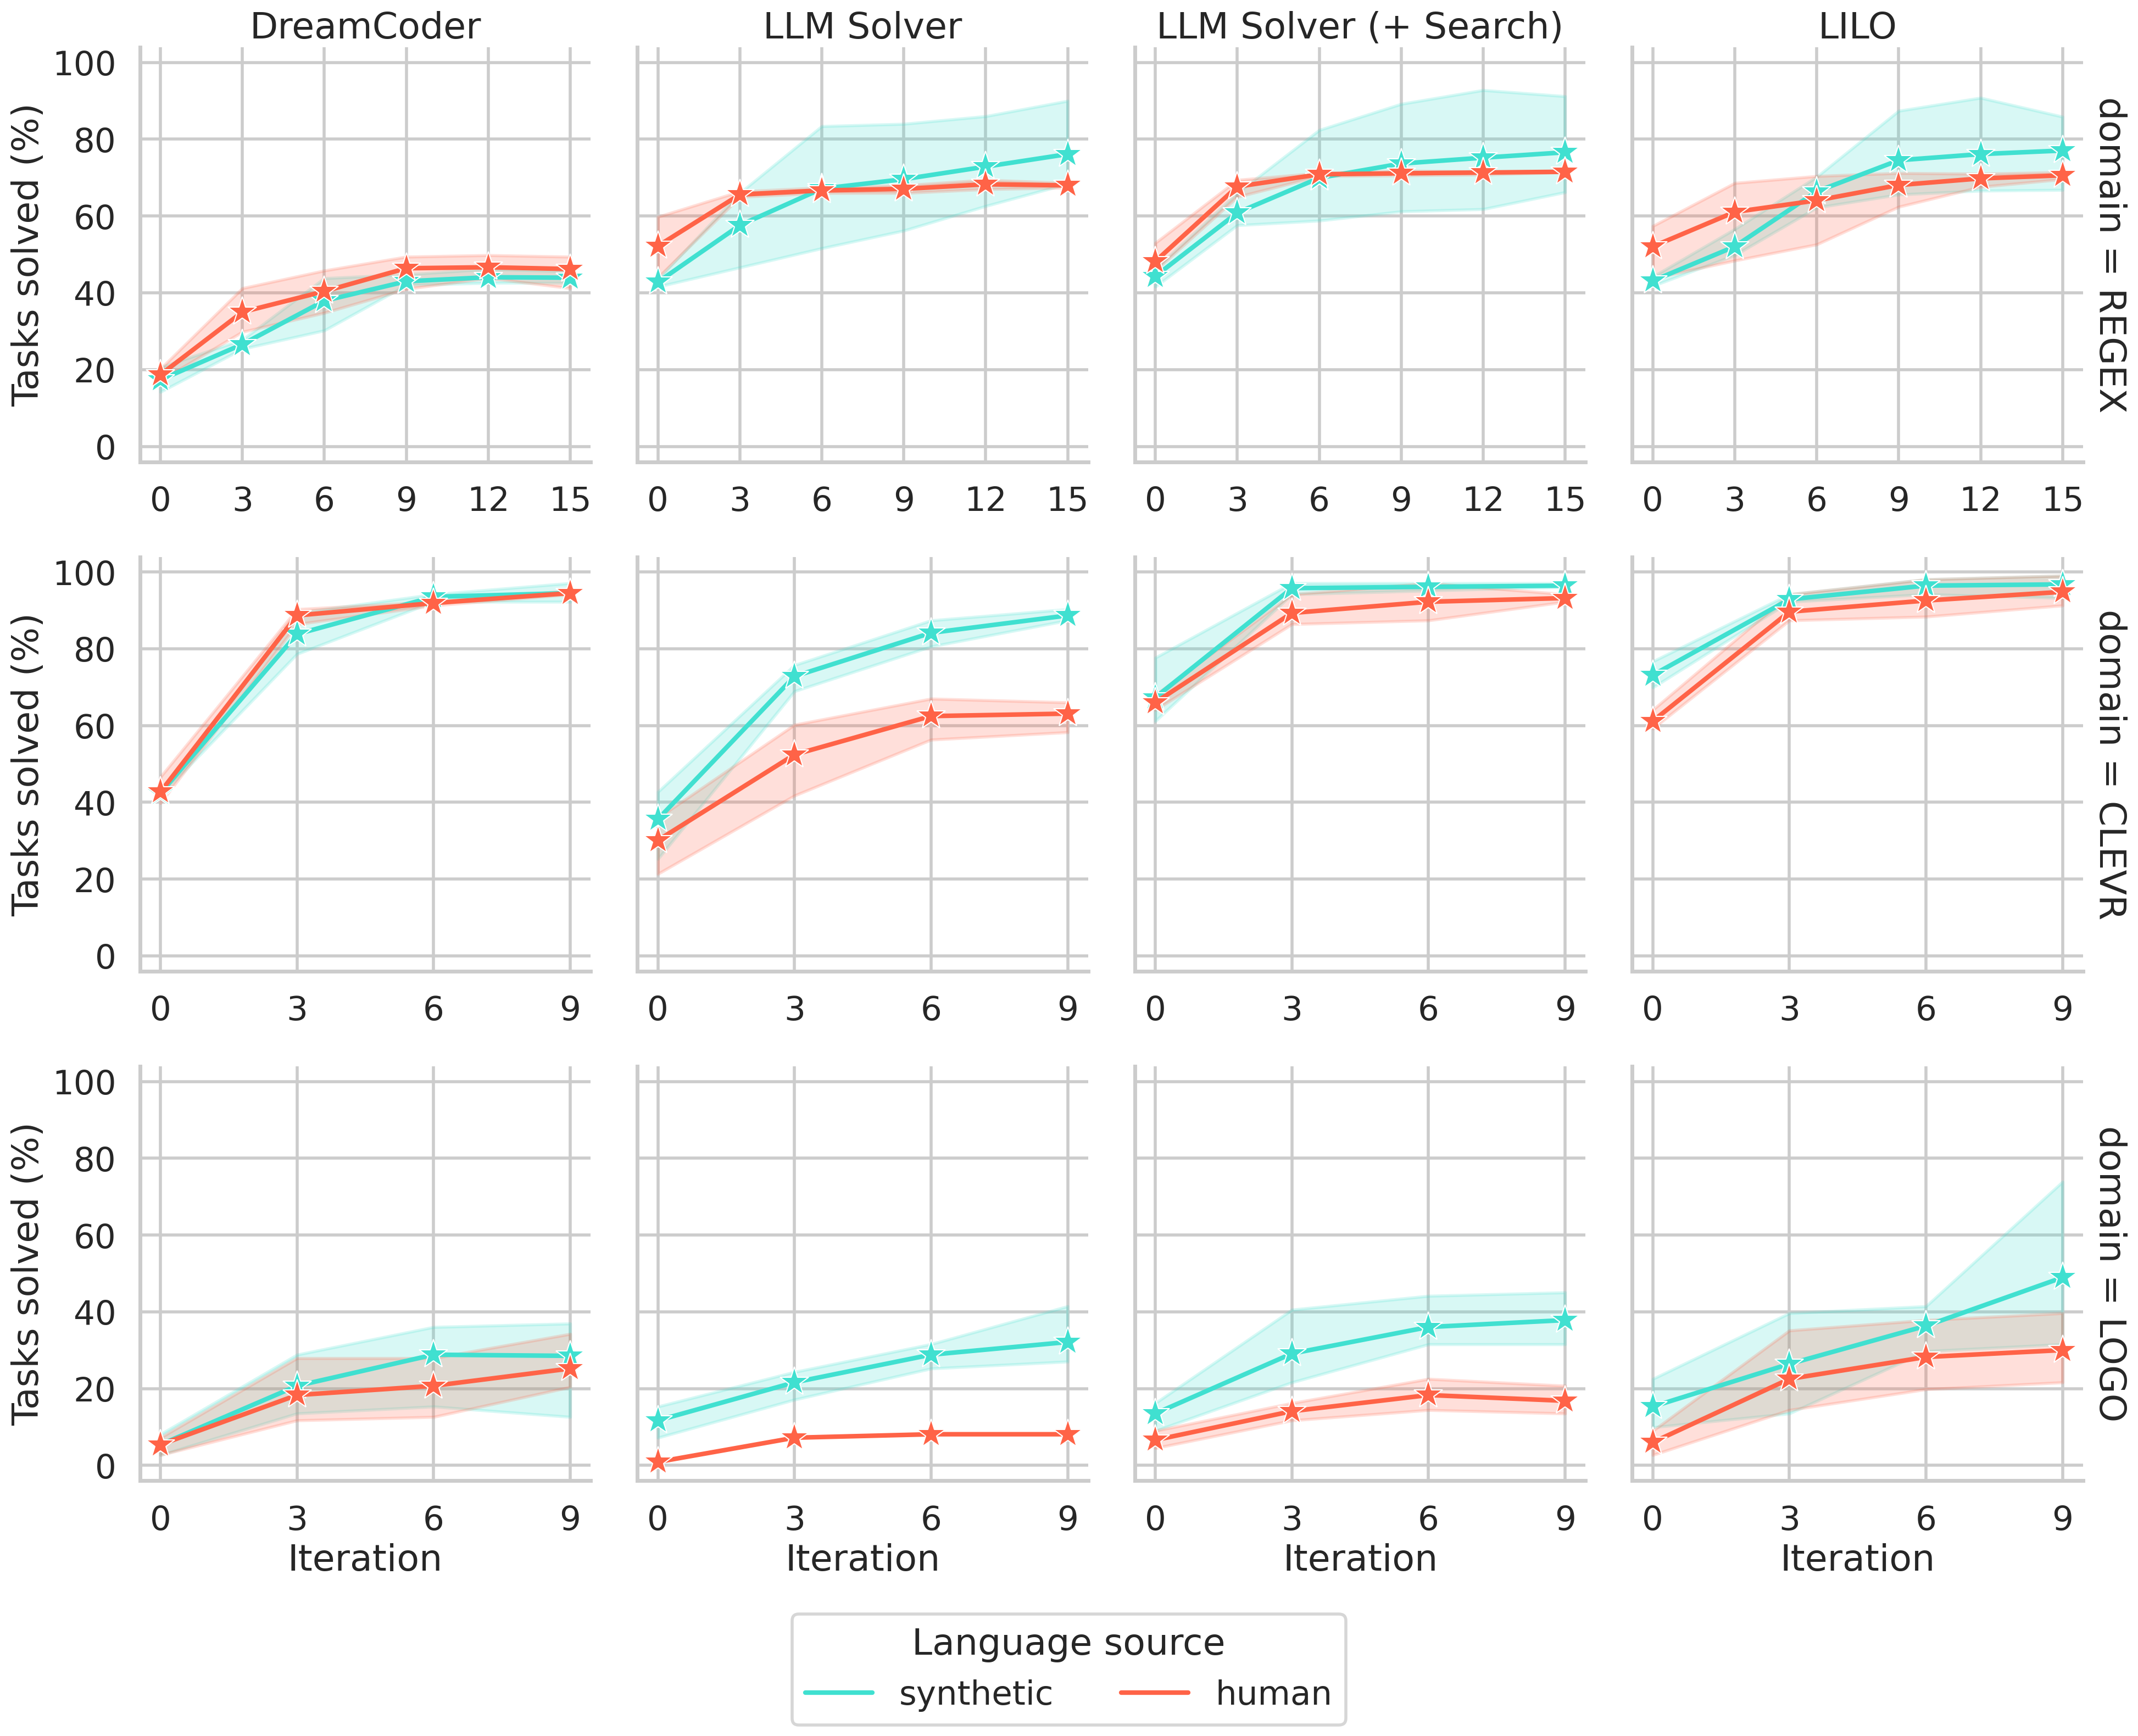

In [14]:
# plot human vs synthetic language 
import matplotlib
analyzer.EXPERIMENT_TYPES_PALETTE['synthetic'] =  '#40E0D0'  
analyzer.EXPERIMENT_TYPES_PALETTE['human'] = '#FF6347'  
with sns.plotting_context("poster", font_scale=1):
    g = sns.relplot(
        data=df_results,
        kind="line",
        row="domain",
        col=analyzer.COL_NAMES_CAMERA["experiment_type"],
        x="Iteration",
        y=analyzer.COL_NAMES_CAMERA["percent_solved"],
        hue = "language",
        marker="*",
        markersize=20,
        row_order = [d for d in list(analyzer.DOMAIN_NAMES_CAMERA.values()) if d in list(df_results["domain"])],
        facet_kws={'sharex': False, 'sharey': True, 'margin_titles': True, 'legend_out': False},
        palette=analyzer.EXPERIMENT_TYPES_PALETTE,
        legend=True,
    )
    for subplot in g.axes[0]:
        subplot.set_title(subplot.title.get_text().split(" = ")[-1])
        
    for ax in g.axes[0]:
        ax.set_xticks(np.arange(0, 16, 3))
    for ax in g.axes[1]:
        ax.set_xticks(np.arange(0, 10, 3))
    for ax in g.axes[2]:
        ax.set_xticks(np.arange(0, 10, 3))

    sns.move_legend(g, title="Language source", loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.075))

    plt.savefig(os.path.join(FIGURES_DIR, "comparison_human_synthetic_language.pdf"), dpi=300, bbox_inches="tight")